In [1]:
import tensortools as tt
import numpy as np
import matplotlib.pyplot as plt


In [2]:
def rank_one_tensor(a, b, c):
    """Returns a rank 1 tensor, given three vectors  
    """
    a = a.reshape(-1, 1).astype(np.float32)
    b = b.reshape(-1, 1).astype(np.float32)
    c = c.reshape(-1, 1).astype(np.float32)
    return np.tensordot(a * b.T, c, axes=0)[:, :, :, 0]

def normalize(x, lower=0, upper=1, axis=0):
    return (x - x.min(axis=axis)) / (x.max(axis=axis) - x.min(axis=axis))


def reconstruct(factors, rank=None):
    a, b, c = factors
    rank = rank if rank else a.shape[1]
    R1s = np.zeros((a.shape[0], b.shape[0], c.shape[0], rank))
    for i in range(rank):
        R1s[:, :, :, i] = rank_one_tensor(a[:, i], b[:, i], c[:, i])
    return R1s.sum(axis=3)

def plot_factors(factors, d=3):
    a, b, c = factors
    rank = a.shape[1]
    fig, axes = plt.subplots(rank, d, figsize=(8, int(rank * 1.2 + 1)))
    factors_name = ["Time", "Features", "Time"] if d==3 else ["Time", "Features"]
    for ind, (factor, axs) in enumerate(zip(factors[:d], axes.T)):
        axs[-1].set_xlabel(factors_name[ind])
        for i, (f, ax) in enumerate(zip(factor.T, axs)):
            sns.despine(top=True, ax=ax)
            ax.plot(f)
            axes[i, 0].set_ylabel("Factor " + str(i+1))
    fig.tight_layout()
    

# Data

In [3]:
import _pickle as pkl
import seaborn as sns
import copy

In [4]:
import os
import glob
import pandas as pd

In [5]:
rootdir = '/n/coxfs01/2p-data'
animalid = 'JC084'
session = '20190522'
fov = 'FOV1_zoom2p0x'
traceid = 'traces001'

experiment = 'blobs'

In [28]:

def check_counts_per_condition(raw_traces, labels):
    # Check trial counts / condn:
    #print("Checking counts / condition...")
    min_n = labels.groupby([b'config'])[b'trial'].unique().apply(len).min()
    conds_to_downsample = np.where( labels.groupby([b'config'])[b'trial'].unique().apply(len) != min_n)[0]
    if len(conds_to_downsample) > 0:
        print("... adjusting for equal reps / condn...")
        d_cfgs = [sorted(labels.groupby([b'config']).groups.keys())[i]\
                  for i in conds_to_downsample]
        trials_kept = []
        for cfg in labels[b'config'].unique():
            c_trialnames = labels[labels[b'config']==cfg][b'trial'].unique()
            if cfg in d_cfgs:
                #ntrials_remove = len(c_trialnames) - min_n
                #print("... removing %i trials" % ntrials_remove)
    
                # In-place shuffle
                random.shuffle(c_trialnames)
    
                # Take the first 2 elements of the now randomized array
                trials_kept.extend(c_trialnames[0:min_n])
            else:
                trials_kept.extend(c_trialnames)
    
        ixs_kept = labels[labels[b'trial'].isin(trials_kept)].index.tolist()
        
        tmp_traces = raw_traces.loc[ixs_kept].reset_index(drop=True)
        tmp_labels = labels[labels[b'trial'].isin(trials_kept)].reset_index(drop=True)
        return tmp_traces, tmp_labels

    else:
        return raw_traces, labels


def group_roidata_stimresponse(roidata, labels_df, roi_list=None, return_grouped=True):
    '''
    roidata: array of shape nframes_total x nrois
    labels:  dataframe of corresponding nframes_total with trial/config info
    
    Returns:
        grouped dataframe, where each group is a cell's dataframe of shape ntrials x (various trial metrics and trial/config info)
    '''
    
#    print('...min')
#    if np.nanmin(roidata) < 0:
#        roidata = roidata - np.nanmin(roidata)
#        print(roidata.min())

    if isinstance(roidata, pd.DataFrame):
        roidata = roidata.values
#    
    try:
        stimdur_vary = False
        assert len(labels_df[b'nframes_on'].unique())==1, "More than 1 idx found for nframes on... %s" % str(list(set(labels_df['nframes_on'])))
        assert len(labels_df[b'stim_on_frame'].unique())==1, "More than 1 idx found for first frame on... %s" % str(list(set(labels_df['stim_on_frame'])))
        nframes_on = int(round(labels_df[b'nframes_on'].unique()[0]))
        stim_on_frame =  int(round(labels_df[b'stim_on_frame'].unique()[0]))
    except Exception as e:
        stimdur_vary = True
        
    groupby_list = [b'config', b'trial']
    config_groups = labels_df.groupby(groupby_list)
    
    if roi_list is None:
        roi_list = np.arange(0, roidata.shape[-1])

    df_list = []
    for (config, trial), trial_ixs in config_groups:
        if stimdur_vary:
            # Get stim duration info for this config:
            assert len(labels_df[labels_df[b'config']==config][b'nframes_on'].unique())==1, "Something went wrong! More than 1 unique stim dur for config: %s" % config
            assert len(labels_df[labels_df[b'config']==config][b'stim_on_frame'].unique())==1, "Something went wrong! More than 1 unique stim ON frame for config: %s" % config
            nframes_on = labels_df[labels_df[b'config']==config][b'nframes_on'].unique()[0]
            stim_on_frame = labels_df[labels_df[b'config']==config][b'stim_on_frame'].unique()[0]
             
        trial_frames = roidata[trial_ixs.index.tolist(), :]
        
        nframes_stim = int(round(nframes_on*1.5))
    
        nrois = trial_frames.shape[-1]
        #base_mean= trial_frames[0:stim_on_frame, :].mean(axis=0)
        base_mean = np.nanmean(trial_frames[0:stim_on_frame, :], axis=0)
        base_std = np.nanstd(trial_frames[0:stim_on_frame, :], axis=0)
        stim_mean = np.nanmean(trial_frames[stim_on_frame:stim_on_frame+nframes_stim, :], axis=0)
        
        df_trace = (trial_frames - base_mean) / base_mean
        bas_mean_df = np.nanmean(df_trace[0:stim_on_frame, :], axis=0)
        bas_std_df = np.nanstd(df_trace[0:stim_on_frame, :], axis=0)
        stim_mean_df = np.nanmean(df_trace[stim_on_frame:stim_on_frame+nframes_stim, :], axis=0)
        
        zscore = (stim_mean - base_mean) / base_std
        #zscore = (stim_mean) / base_std
        dff = (stim_mean - base_mean) / base_mean
        dF = stim_mean - base_mean
        snr = stim_mean / base_mean
        df_list.append(pd.DataFrame({'config': np.tile(config, (nrois,)),
                                     'trial': np.tile(trial, (nrois,)), 
                                     'stim_mean': stim_mean, # called meanstim ...
                                     'zscore': zscore,
                                     'dff': dff,
                                     'df': dF, 
                                     'snr': snr,
                                     'base_std': base_std,
                                     'base_mean': base_mean,
                                     
                                     'stim_mean_df': stim_mean_df,
                                     'bas_mean_df': bas_mean_df,
                                     'bas_std_df': bas_std_df
                                     
                                     }, index=roi_list))

    df = pd.concat(df_list, axis=0) # size:  ntrials * 2 * nrois\
    if return_grouped:    
        df_by_rois = df.groupby(df.index)
        return df_by_rois
    else:
        return df



def load_data(data_fpath, add_offset=True, make_equal=False):
    soma_fpath = data_fpath.replace('datasets', 'np_subtracted')
    print(soma_fpath)
    dset = np.load(soma_fpath, allow_pickle=True)
    
    xdata_df = pd.DataFrame(dset['data'][:]) # neuropil-subtracted & detrended
    F0 = pd.DataFrame(dset['f0'][:]).mean().mean() # detrended offset
    #neuropil_df = pd.concat(dfs['neuropil-detrended'], axis=0).reset_index(drop=True) #drop=True)
    #neuropil_F0 = pd.concat(dfs['np_subtracted-F0'], axis=0).reset_index(drop=True).mean() #drop=True)

    if add_offset:
        #% Add baseline offset back into raw traces:
        neuropil_fpath = soma_fpath.replace('np_subtracted', 'neuropil')
        npdata = np.load(neuropil_fpath, allow_pickle=True)
        neuropil_df = pd.DataFrame(npdata['data'][:]) #+ pd.DataFrame(npdata['f0'][:])
        print("adding NP offset...")
        raw_traces = xdata_df + neuropil_df.mean(axis=0) + F0 #neuropil_F0 + F0
    else:
        raw_traces = xdata_df + F0

    labels = pd.DataFrame(data=dset['labels_data'], columns=dset['labels_columns'])
    
    print(labels.head())
    if make_equal:
        raw_traces, labels = check_counts_per_condition(raw_traces, labels)

    sdf = pd.DataFrame(dset['sconfigs'][()]).T
    
    gdf = group_roidata_stimresponse(raw_traces.values, labels, return_grouped=True) # Each group is roi's trials x metrics
    
    #% # Convert raw + offset traces to df/F traces
    #min_mov = raw_traces.min().min()
    #if min_mov < 0:
    #    raw_traces = raw_traces - min_mov

#     stim_on_frame = labels['stim_on_frame'].unique()[0]
#     tmp_df = []
#     for k, g in labels.groupby(['trial']):
#         tmat = raw_traces.loc[g.index]
#         bas_mean = np.nanmean(tmat[0:stim_on_frame], axis=0)
#         tmat_df = (tmat - bas_mean) / bas_mean
#         tmp_df.append(tmat_df)
#     df_traces = pd.concat(tmp_df, axis=0)
#     del tmp_df

    return raw_traces, labels, gdf, sdf

def process_traces(raw_traces, labels, response_type='dff'):

    stim_on_frame = labels[b'stim_on_frame'].unique()[0]
    tmp_df = []
    for k, g in labels.groupby([b'trial']):
        tmat = raw_traces.loc[g.index]
        bas_mean = np.nanmean(tmat[0:stim_on_frame], axis=0)
        if response_type == 'dff':
            tmat_df = (tmat - bas_mean) / bas_mean
        elif response_type == 'zscore':
            bas_std = np.nanstd(tmat[0:stim_on_frame], axis=0)
            tmat_df = (tmat - bas_mean) / bas_std
        tmp_df.append(tmat_df)
    processed_traces = pd.concat(tmp_df, axis=0)
    
    return processed_traces

In [36]:
import traceback
def get_responsive_cells(animalid, session, fov, run=None, traceid='traces001',
                         response_type='dff',
                         responsive_test='ROC', responsive_thr=0.05, n_stds=2.5,
                         rootdir='/n/coxfs01/2p-data'):
        
    roi_list=None; nrois_total=None;
    try:
        traceid_dir =  glob.glob(os.path.join(rootdir, animalid, session, fov, run, 'traces', '%s*' % traceid))[0]        
        stats_dir = os.path.join(traceid_dir, 'summary_stats', responsive_test)
        stats_fpath = glob.glob(os.path.join(stats_dir, '*results*.pkl'))
        assert len(stats_fpath) > 0, "No stats results found for: %s" % stats_dir
        with open(stats_fpath[0], 'rb') as f:
            rstats = pkl.load(f, allow_pickle=True)
        if responsive_test == 'ROC':
            roi_list = [r for r, res in rstats.items() if res['pval'] < responsive_thr]
            nrois_total = len(rstats.keys())
        elif responsive_test == 'nstds':
            assert n_stds == rstats['nstds'], "... incorrect nstds, need to recalculate"
            roi_list = [r for r in rstats['nframes_above'].columns if any(rstats['nframes_above'][r] > responsive_thr)]
            nrois_total = rstats['nframes_above'].shape[-1]
    except Exception as e:
        traceback.print_exc()
    
    return roi_list, nrois_total

In [26]:
dfn = glob.glob(os.path.join(rootdir, animalid, session, fov, 'combined_%s*' % experiment, 'traces', '%s*' % traceid, 'data_arrays', 'datasets.npz'))[0]
dfn

'/n/coxfs01/2p-data/JC084/20190522/FOV1_zoom2p0x/combined_blobs_static/traces/traces001_ea0b53_traces001_92d492_traces001_af4cfd_traces001_9188fa_traces001_b44714_traces001_133108/data_arrays/datasets.npz'

In [27]:
raw_traces, labels, gdf, sdf = load_data(dfn)

/n/coxfs01/2p-data/JC084/20190522/FOV1_zoom2p0x/combined_blobs_static/traces/traces001_ea0b53_traces001_92d492_traces001_af4cfd_traces001_9188fa_traces001_b44714_traces001_133108/data_arrays/np_subtracted.npz
adding NP offset...
   b'config' b'stim_dur'    b'trial'   b'tsec' b'stim_on_frame' b'nframes_on'  \
0  config032           1  trial00001   -1.0078               45            45   
1  config032           1  trial00001 -0.985407               45            45   
2  config032           1  trial00001 -0.963011               45            45   
3  config032           1  trial00001 -0.940615               45            45   
4  config032           1  trial00001  -0.91822               45            45   

  b'run_ix' b'file_ix'  
0         0          0  
1         0          0  
2         0          0  
3         0          0  
4         0          0  


In [29]:
dff_traces = process_traces(raw_traces, labels, response_type='dff')

In [ ]:
get_responsive_cells(animalid, session)

In [35]:
dff_traces.shape

(268500, 260)

In [215]:
#traces = process_traces(traces, labels)

In [384]:
outdir

NameError: name 'outdir' is not defined

# Get responsive cells only

In [37]:
responsive_test = 'nstds'
responsive_thr = 10.
n_stds = 2.5

stats_fpath = glob.glob(os.path.join(rootdir, animalid, session, fov, 'combined_%s*' % experiment, 
                                    'traces', '%s*' % traceid, 'summary_stats', responsive_test, '*.pkl'))[0]
with open(stats_fpath, 'rb') as f:
    rstats = pkl.load(f, fix_imports=True, encoding='latin1')

    

In [38]:
if responsive_test == 'ROC':
    roi_list = [r for r, res in rstats.items() if res['pval'] < responsive_thr]
    nrois_total = len(rstats.keys())
elif responsive_test == 'nstds':
    assert n_stds == rstats['nstds'], "... incorrect nstds, need to recalculate"
    roi_list = [r for r in rstats['nframes_above'].columns if any(rstats['nframes_above'][r] > responsive_thr)]
    nrois_total = rstats['nframes_above'].shape[-1]
print("%i out of %i cells responsive." % (len(roi_list), nrois_total))

180 out of 260 cells responsive.


In [32]:
from statsmodels.nonparametric.smoothers_lowess import lowess
def smooth_traces(trace, frac=0.002):
    missing='none'
    '''
    lowess algo (from docs):

    Suppose the input data has N points. The algorithm works by estimating the
    smooth y_i by taking the frac*N closest points to (x_i,y_i) based on their
    x values and estimating y_i using a weighted linear regression. The weight
    for (x_j,y_j) is tricube function applied to abs(x_i-x_j).

    Set 'missing' to 'drop' to ignore NaNs. Set 'return_sorted' to False to
    return array of the same sequence as input (doesn't omit NaNs)
    '''
    xvals = np.arange(len(trace))
    filtered = lowess(trace, xvals, is_sorted=True, frac=frac, it=0, missing=missing, return_sorted=False)
    if len(filtered.shape) > 1:
        return filtered[:, 1]
    else:
        return filtered



In [42]:
dff_traces.shape

(268500, 260)

In [40]:
threshold_dff = True
min_dff = 0.03


In [43]:

meanr = pd.concat([pd.Series(gdf.get_group(roi).groupby(['config']).mean()['dff'], name=roi) \
                   for roi in roi_list], axis=1).T

# Get ROI list
if threshold_dff:
    rois_plot = meanr[(meanr.max(axis=1) > min_dff)].index.tolist()
else:
    rois_plot = meanr.index.tolist()
print("Plotting %i of %i responsive cells." % (len(rois_plot), len(meanr.index.tolist())))

traces = dff_traces[rois_plot]
print(traces.shape)

Plotting 168 of 180 responsive cells.
(268500, 168)


In [52]:
meanr.shape

(180, 50)

In [45]:
frac = 0.003
smooth = True
if smooth:
    smoothed = traces.apply(smooth_traces, frac=frac) #axis=0)


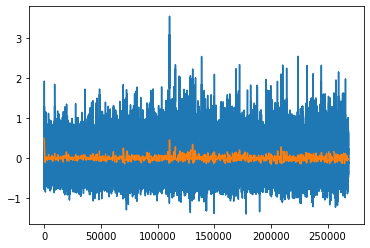

In [46]:
plt.figure()
plt.plot(traces[12])
plt.plot(smoothed[12])


[1,
 5,
 6,
 7,
 9,
 10,
 11,
 12,
 14,
 17,
 18,
 19,
 20,
 21,
 23,
 24,
 25,
 27,
 28,
 33,
 34,
 35,
 36,
 39,
 40,
 41,
 43,
 44,
 45,
 48,
 49,
 51,
 53,
 54,
 55,
 56,
 57,
 58,
 59,
 61,
 63,
 64,
 65,
 66,
 67,
 68,
 69,
 70,
 71,
 72,
 74,
 75,
 77,
 79,
 80,
 82,
 84,
 86,
 88,
 89,
 90,
 91,
 93,
 94,
 95,
 97,
 99,
 100,
 101,
 102,
 103,
 106,
 107,
 108,
 109,
 110,
 112,
 113,
 115,
 116,
 117,
 118,
 119,
 121,
 122,
 123,
 124,
 125,
 126,
 128,
 129,
 132,
 134,
 135,
 136,
 137,
 138,
 139,
 140,
 141,
 142,
 143,
 145,
 147,
 148,
 150,
 151,
 152,
 153,
 155,
 159,
 160,
 162,
 163,
 165,
 166,
 167,
 168,
 170,
 171,
 173,
 174,
 175,
 177,
 178,
 179,
 180,
 181,
 183,
 184,
 187,
 188,
 190,
 191,
 193,
 194,
 195,
 196,
 199,
 200,
 201,
 203,
 205,
 207,
 208,
 210,
 211,
 212,
 213,
 214,
 215,
 216,
 217,
 218,
 219,
 220,
 222,
 223,
 225,
 227,
 228,
 230,
 231,
 232,
 233,
 234,
 235,
 236,
 237,
 238,
 239,
 241,
 242,
 243,
 245,
 246,
 249,
 251,
 255

In [74]:
use_smoothed = False

In [75]:
if use_smoothed:
    tdf = np.dstack([smoothed[rois_plot].loc[g.index.tolist()].T for k, g in labels.groupby([b'trial']) \
                    if len(np.where(np.isnan(smoothed.loc[g.index.tolist()].T))[0])==0])
    trial_list = [k for k, g in labels.groupby([b'trial']) if len(np.where(np.isnan(smoothed.loc[g.index.tolist()].T))[0])==0]
else:
    tdf = np.dstack([traces[rois_plot].loc[g.index.tolist()].T for k, g in labels.groupby([b'trial']) \
                    if len(np.where(np.isnan(traces.loc[g.index.tolist()].T))[0])==0])
    trial_list = [k for k, g in labels.groupby([b'trial']) if len(np.where(np.isnan(traces.loc[g.index.tolist()].T))[0])==0]

    
print(tdf.shape)
print("n trials: %i" % len(trial_list))

(168, 179, 1447)
n trials: 1447


In [179]:
X = tdf.copy()
X.shape
rank=10

In [180]:
#%pip install statsmodels

In [181]:
X.shape

(168, 179, 1447)

In [182]:
# Perform CP decomposition using tensortools
U = tt.cp_als(X, rank=rank, verbose=False)
factors_tt = U.factors.factors

In [183]:
# Reconstruct M, with the result of each library
M_tt = reconstruct(factors_tt)

In [184]:
# Compute the reconstruction error
rec_error_tt = np.mean((X-M_tt)**2)
print(rec_error_tt)

0.10930615676329807


In [185]:
factors_tt[0].shape

(168, 10)

In [186]:
# plot the decomposed factors from TensorLy
#plot_factors(factors_tt, d=3)
#plt.suptitle("Factors computed with tensortool", y=1.1, fontsize=20);

In [187]:
a, b, c = factors_tt
rank = a.shape[1]
print("rank: %i" % rank)


rank: 10


In [188]:
sdf = pd.DataFrame(dset['sconfigs'][()]).T.sort_index()
if experiment == 'blobs':
    sizes = sorted([round(i) for i in sdf['size'].unique() if i is not None])
    morphs = sorted([round(i) for i in sdf['morphlevel'].unique()])

    control_ixs = sdf[sdf['color']!=''].index.tolist()
    sdf.loc[control_ixs, 'size'] = sizes
    sdf['size'] = [round(i) for i in sdf['size'].values]


In [189]:
experiment

'blobs'

In [190]:
sdf.head()

,xpos,color,object,ypos,morphlevel,stimtype,yrot,size
config001,None,0.08,control,None,-1,image,0,10
config002,None,0.2,control,None,-1,image,0,20
config003,None,0.32,control,None,-1,image,0,30
config004,None,0.44,control,None,-1,image,0,40
config005,None,0.56,control,None,-1,image,0,50


In [191]:
outdir = os.path.join('/n/coxfs01/julianarhee/aggregate-visual-areas/tensors')
if not os.path.exists(outdir):
    os.makedirs(outdir)
print(outdir)

/n/coxfs01/julianarhee/aggregate-visual-areas/tensors


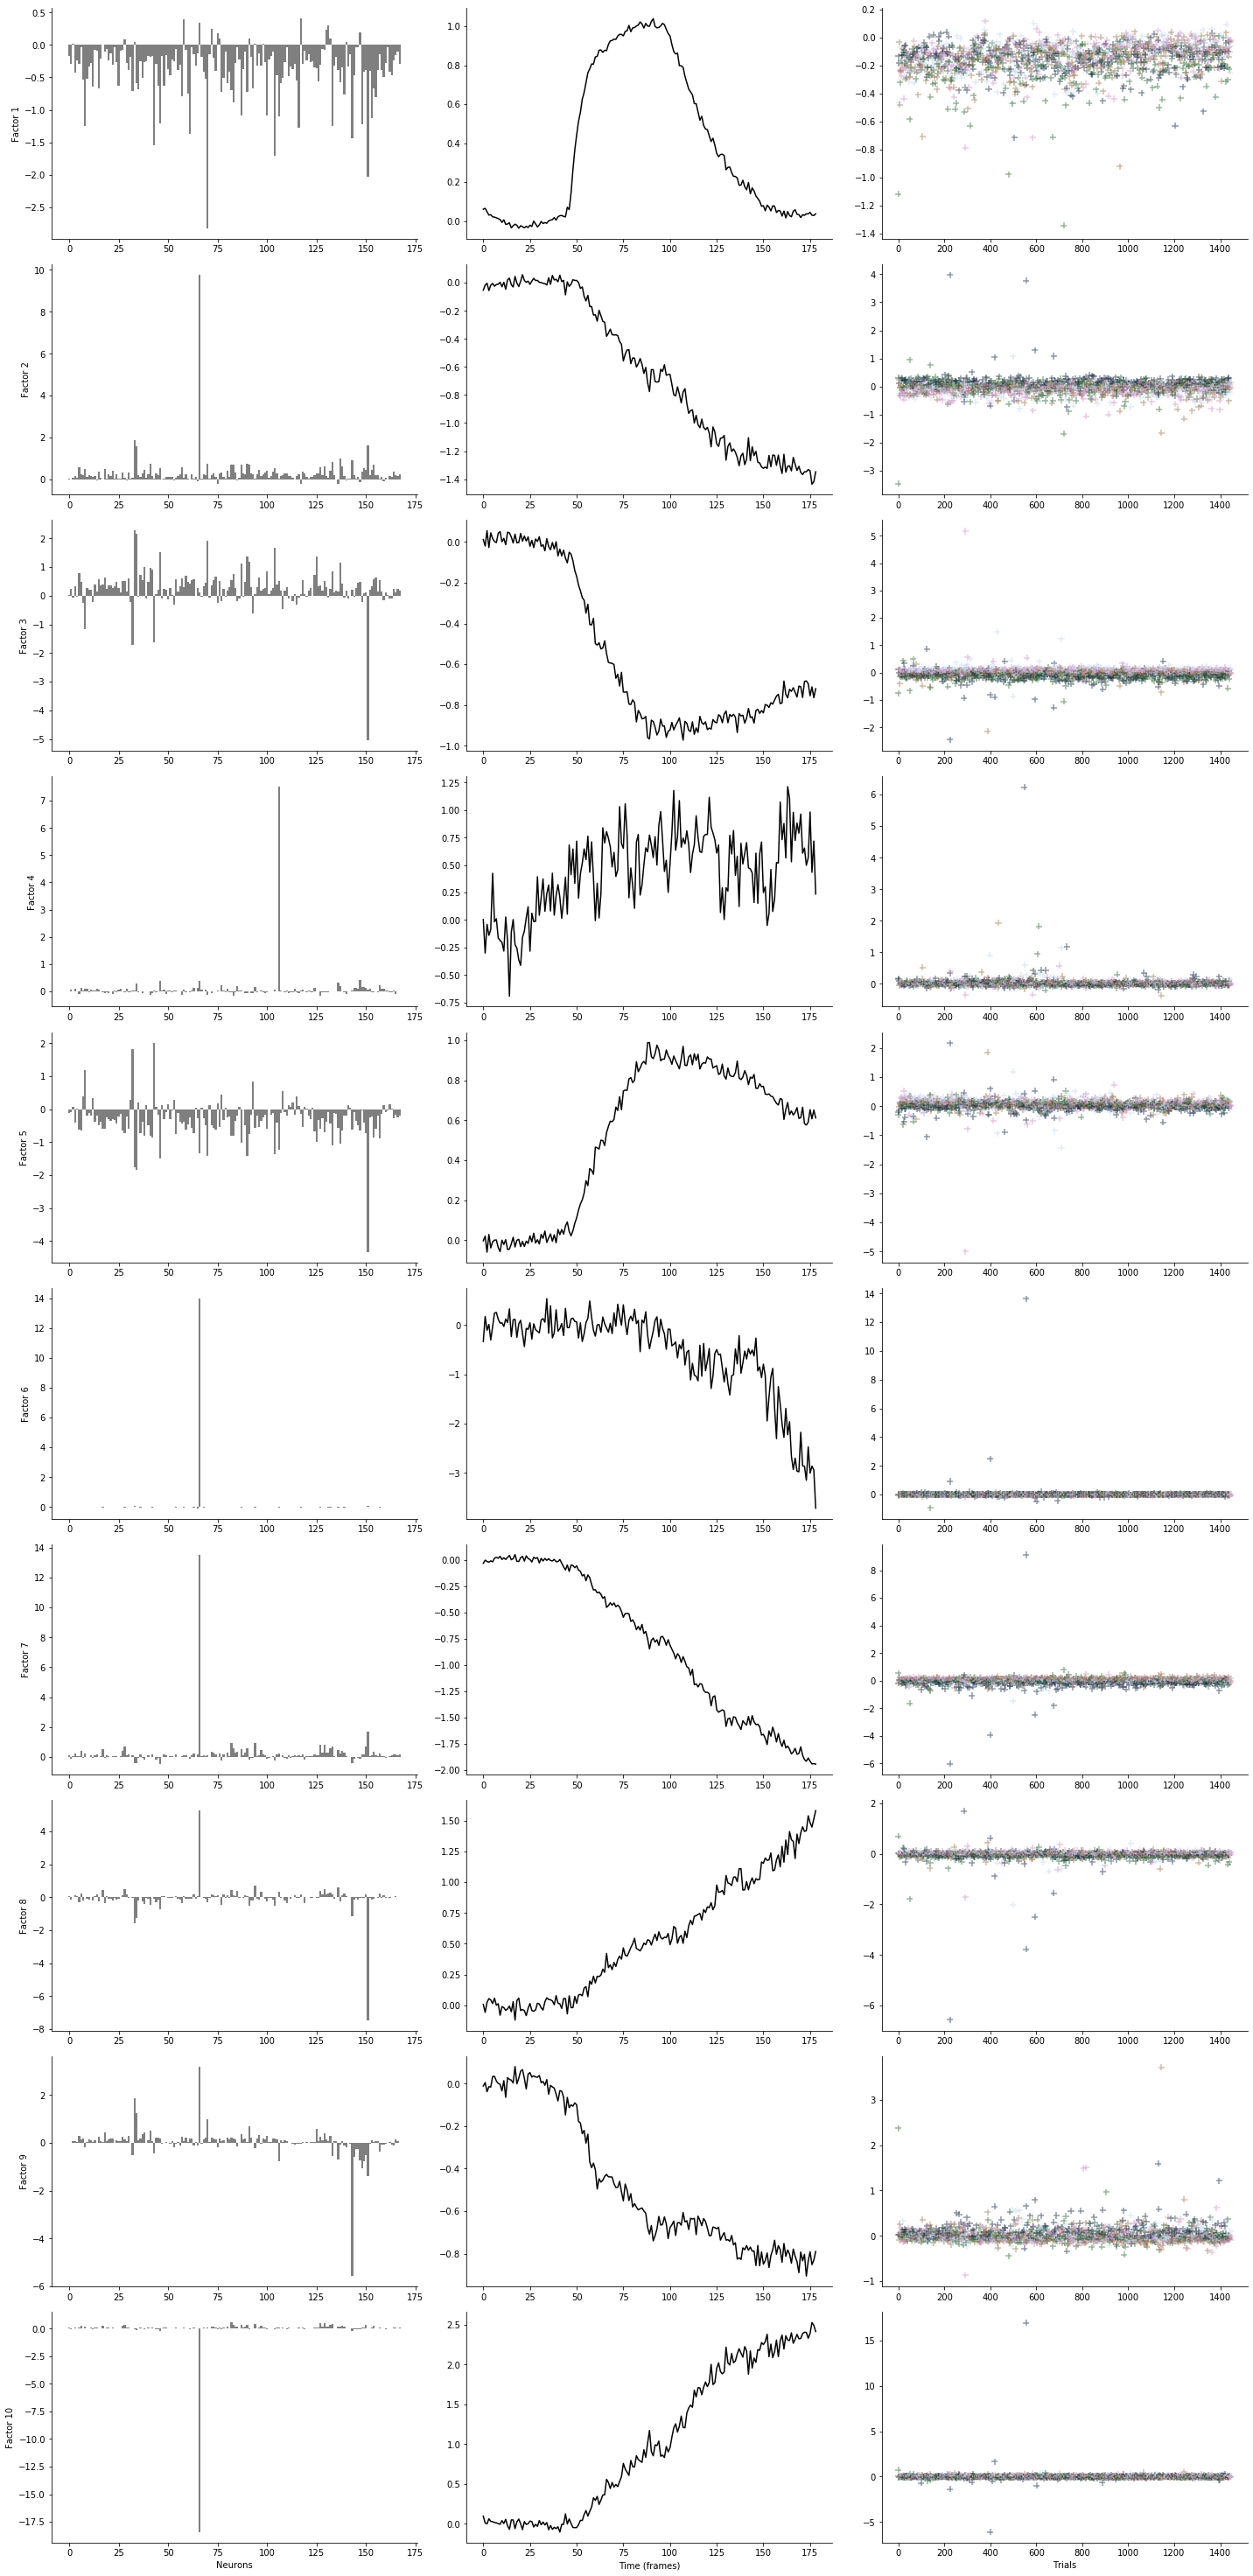

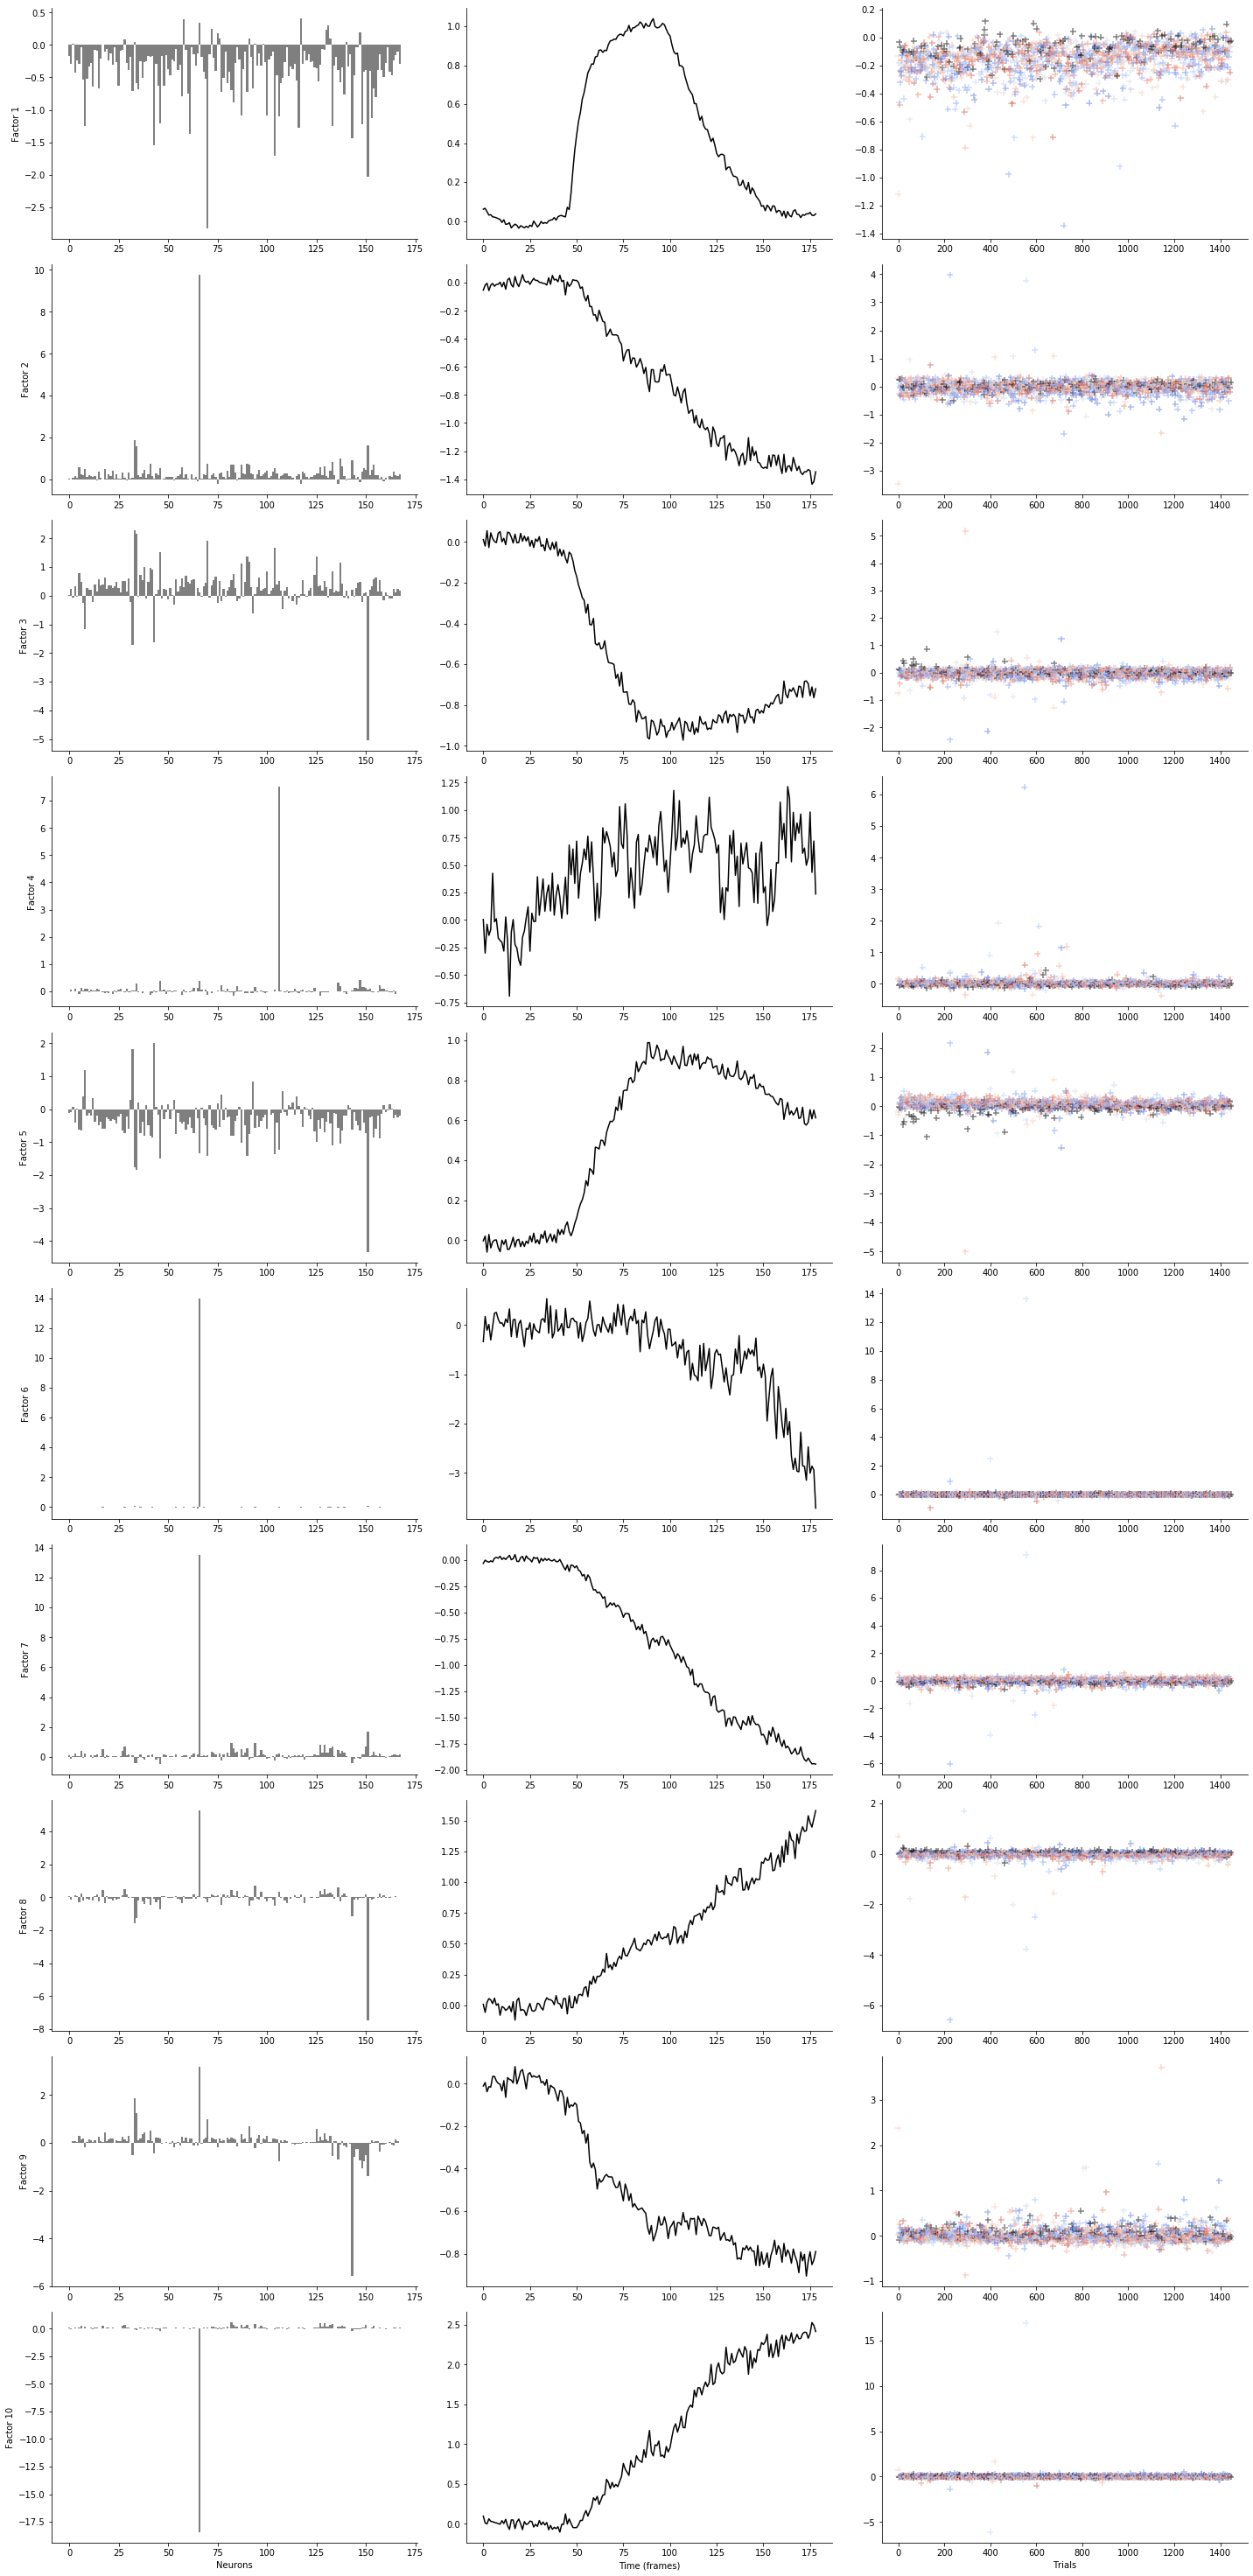

In [192]:
markersize=50
marker='+'
for color_by in ['size', 'morphlevel']:
    #color_by = 'sf' # 14?
    #color_by = 'speed' #9?
    #color_by = 'size'
    #color_by = 'ori'

    #assert color_by in sdf.columns.tolist(), "Parameter not found: %s" % color_by
    if experiment == 'blobs':
        if color_by == 'size':
            cvalues = copy.copy(sizes)
            colormap = 'cubehelix'
        else:
            cvalues = copy.copy(morphs)
            colormap = 'coolwarm'
            
    elif experiment == 'gratings':
        cvalues = copy.copy(sorted(sdf[color_by].unique()))
        colormap = 'cubehelix'
        
    ccolor = sns.color_palette(colormap, n_colors=len(cvalues))
    if color_by == 'morphlevel':
        ccolor[0] = (0, 0, 0)
        new_colors = sns.color_palette(colormap, n_colors=len(cvalues)-1)
        ccolor[1:] = new_colors

    colordict = dict((sz, col) for sz, col in zip(cvalues, ccolor))

    config_in_trial = [g[b'config'].values[0] for k, g in labels[labels[b'trial'].isin(trial_list)].groupby([b'trial'])]


    color_array = [colordict[sdf[color_by][c]] for c in config_in_trial]
    len(color_array)

    # Plot -----------------------------------------
    d=3
    fig, axes = plt.subplots(rank, d,  figsize=(20, int(rank * 4 + 1)))
    factors_name = ["Neurons", "Time (frames)", "Trials"] 
    for ind, (factor, axs) in enumerate(zip(factors_tt[:d], axes.T)):
        axs[-1].set_xlabel(factors_name[ind])
        for i, (f, ax) in enumerate(zip(factor.T, axs)):
            sns.despine(top=True, ax=ax)
            if ind == (d-1):
                if color_by == 'speed':
                    midp = int(round(len(f)/2.))
                    ax.scatter(np.arange(0, midp), f[0:midp], marker=marker, s=markersize, 
                               c=color_array[0:midp], alpha=0.6)
                    ax.scatter(np.arange(0, len(f[midp:])), f[midp:], marker=marker, s=markersize, 
                               c=color_array[midp:], alpha=0.5)
                else:
                    ax.scatter(np.arange(0, len(f)), f, marker=marker, s=markersize, 
                               c=color_array, alpha=0.5)
            elif ind == 0:
                ax.bar(list(range(len(f))), f, width=1, alpha=0.5, linewidth=2, color='k')
            else:
                ax.plot(f, color='k')
            axes[i, 0].set_ylabel("Factor " + str(i+1))
    fig.tight_layout()

    skey = '-'.join([animalid, session, fov])

    plt.savefig(os.path.join(outdir, '%s_rank-%i_tensor-decomp_%s__%s.png' % (experiment, rank, color_by, skey)))
    #plt.close()

<BarContainer object of 1447 artists>

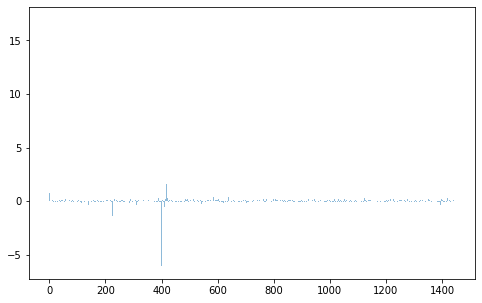

In [193]:
plt.figure(figsize=(8,5))
plt.bar(list(range(len(f))), f, width=1, alpha=0.5, linewidth=2)

In [194]:
np.linspace(0, 5*10, 5)

array([ 0. , 12.5, 25. , 37.5, 50. ])